<a href="https://colab.research.google.com/github/sethharris17/sethharris-P2-portfolio/blob/main/Seth_Harris_IS6733Lab2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 2: Convolutional Neural Networks for Computer Vision

In this lab, we will learn how to use CNNs for computer vision applications. We will look at two applications - 1) detecting objects in images, and 2) detecting cyberbullying in images.

Grading Breakdown:

Part 1: Detecting objects 70%

Part 2: Detecting cyberbullying 30%

## Part 1: CNN to Detect Images of 10 Objects

In this section, we will design a CNN to classify images of 10 objects from the CIFAR10 dataset.
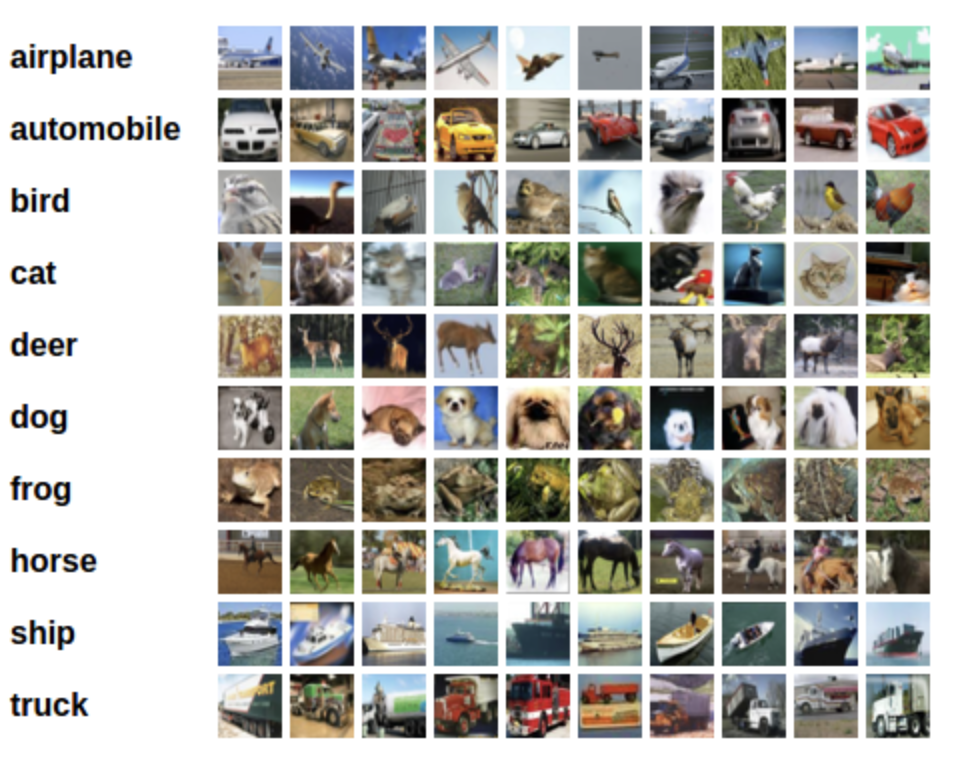

In [ ]:
# Import packages first
import torch
import torchvision
import torchvision.transforms as transforms

In [ ]:
# Just like in Lab 1, we willnormalize our inputs. As we go along, notice the recurring themes in deep learning, such as data normalizqation, data set and loader, optimizer, loss function etc...
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# set a batch size
batch_size = 4

# download the train set
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
# we'll just split the train into train and val
trainset, valset = torch.utils.data.random_split(trainset, [0.8, 0.2])
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=True, num_workers=2)

# download the train set
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

# labels. In this problem there are 10 labels.
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


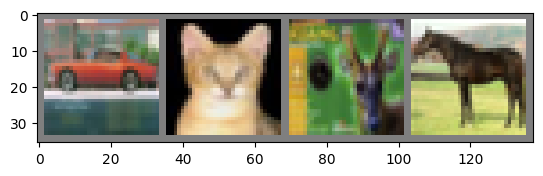

car   cat   deer  horse


In [ ]:
# Visualize a few images in the train set
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

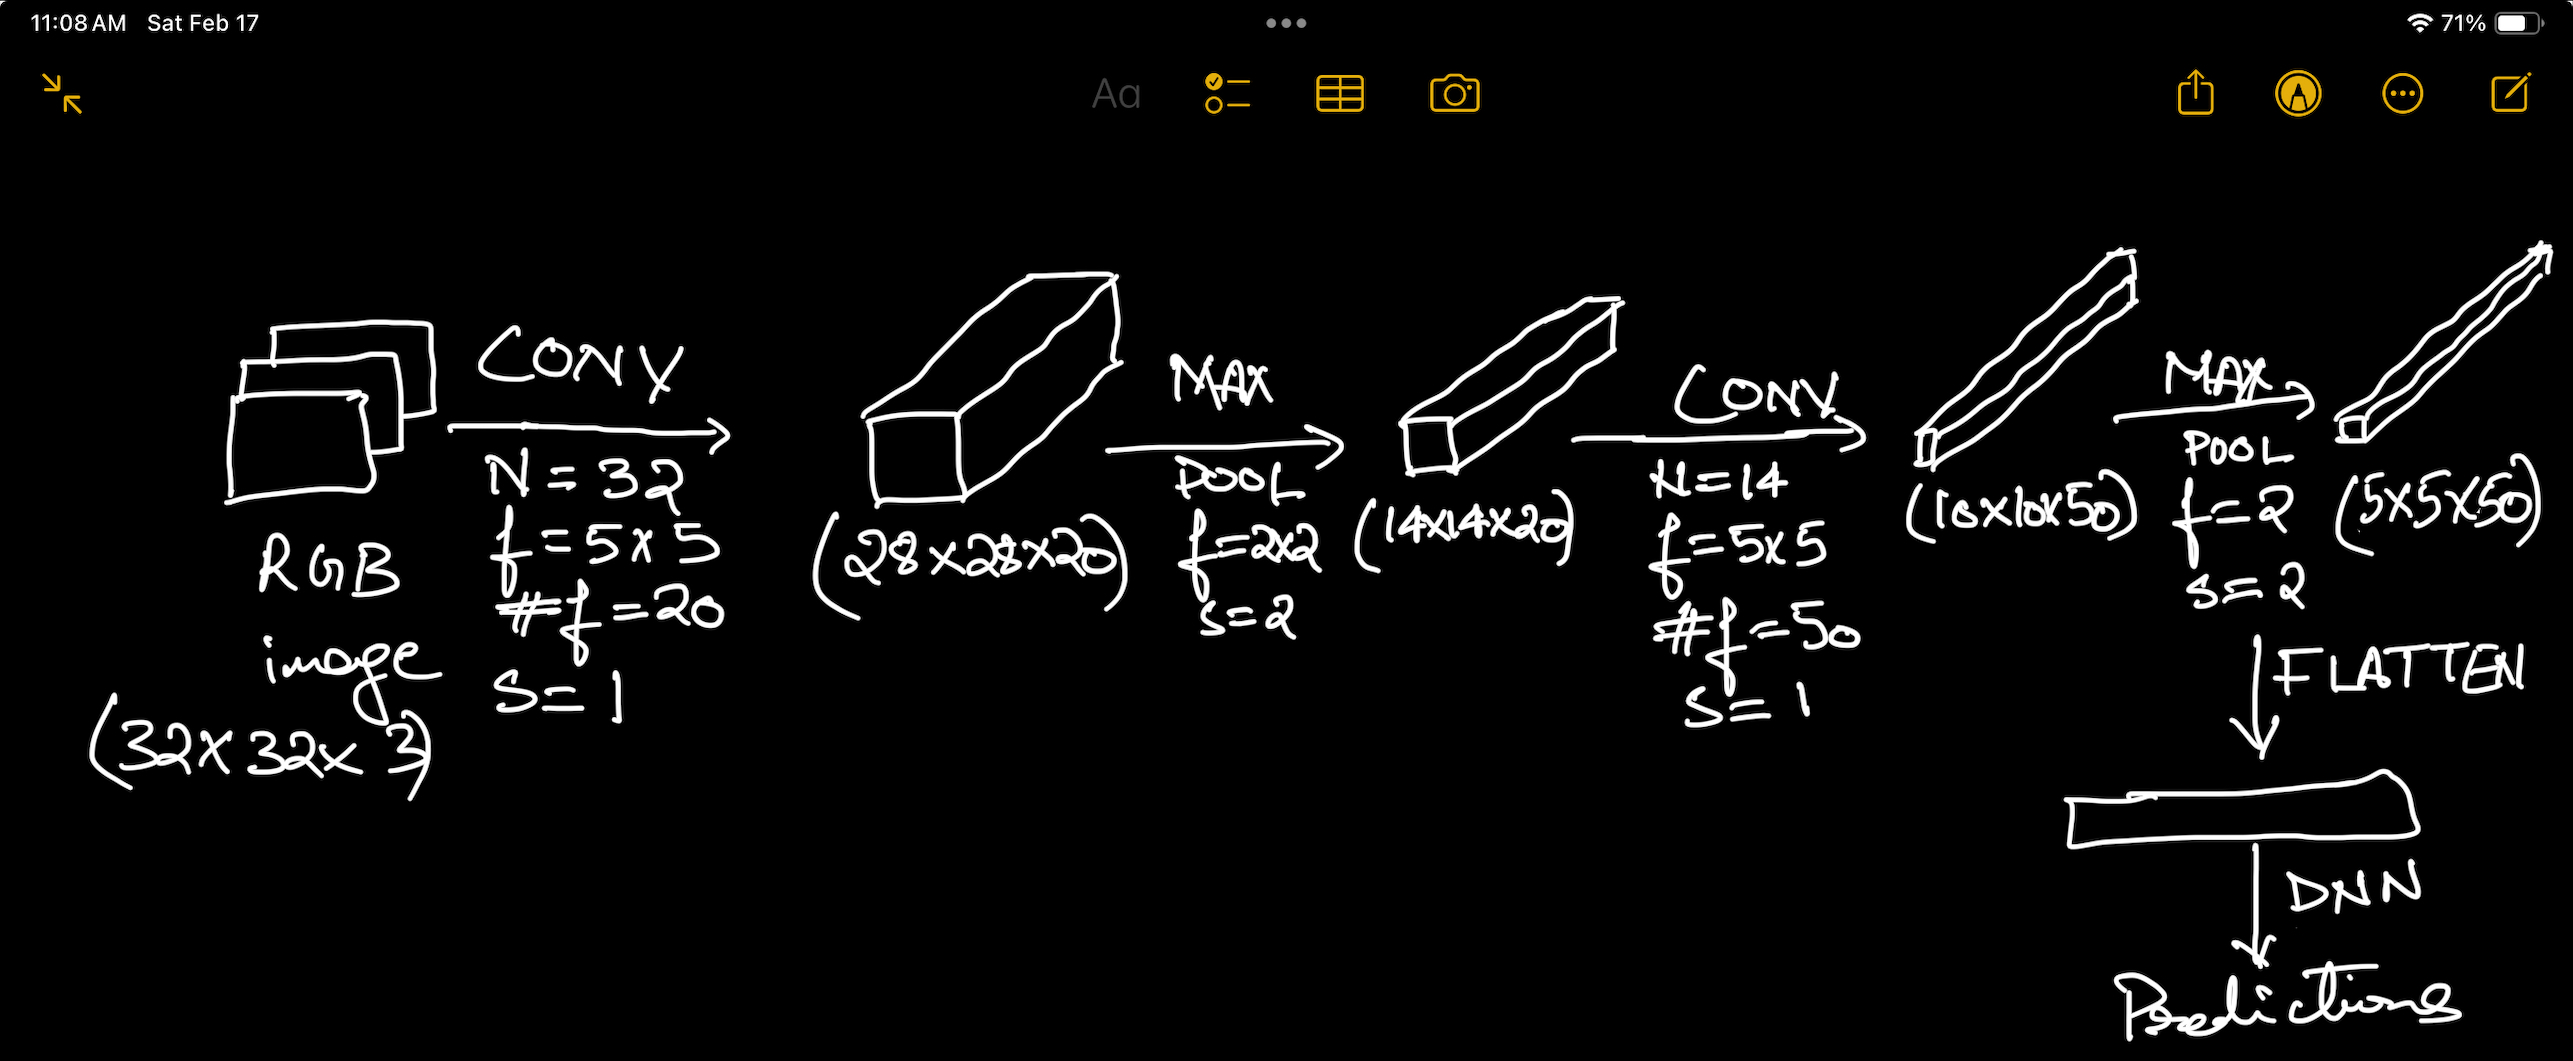

In [ ]:
# CNN Architecture
import torch
import torch.nn as nn
import torch.nn.functional as F

class MyObjDetectorCNN(nn.Module):
    def __init__(self):
        super(MyObjDetectorCNN, self).__init__()

        # this is the conv net part
        self.convolutional_layer = nn.Sequential(
            # we can use the equation ((N + 2p - f) / s) + 1 to quickly compute the output of a convolution op.
            # however, PyTorch makes it easy for us, since it computes this equation for us. All we have to do is tell it the number of channels we want
            # in the input and the output. For the first convolution layer, the in_channels would be the channels a standard RGB image has. Let's say we want
            # number of channels in the output to be 20. We want to use 5X5 convolutions and single strides. Write the convolution layers.
            # First convolutional layer with an input of 3, output of 20, kernel size of 5x5, and stride of 1
            nn.Conv2d(in_channels = 3, out_channels = 20, kernel_size = 5, stride = 1),
            nn.ReLU(),
            # Lets subsample after convolution. We will use Max Pooling in this example. Kernel size of 2 and stride of 2
            nn.MaxPool2d(kernel_size = 2,stride = 2),
            # Second convolutional layer with an input of 20, output of 50, kernel size of 5x5, and stride of 1
            nn.Conv2d(in_channels = 20, out_channels = 50, kernel_size = 5, stride = 1),
            nn.ReLU(),
            # Subsample again with kernel size of 2 and stride of 2
            nn.MaxPool2d(kernel_size = 2, stride = 2),

        )

        # this is the classifier head. So the model is actually CNN + DNN. We will flatten the output from the CNN above for the DNN.
        self.linear_layer = nn.Sequential(
            nn.Linear(in_features = 50 * 5 * 5, out_features = 500),
            nn.ReLU(),
            nn.Linear(in_features = 500, out_features = 10), # observe how we have output features = 10. There are 10 classes in this problem.
        )


    def forward(self, x):
        x = self.convolutional_layer(x)
        x = torch.flatten(x, 1) # Flattening the output of the CNN for the DNN
        x = self.linear_layer(x)
        x = F.softmax(x, dim = 1)
        return x

net = MyObjDetectorCNN()

In [ ]:
# define a loss function and opimizer
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr = 0.001, momentum = 0.9)

In [ ]:
# train the network (better use a GPU for this, look at the first lab for moving objects to GPU)
net.train()
for epoch in range(2):  # loop over the dataset multiple times, you could increase this.

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.301
[1,  4000] loss: 2.266
[1,  6000] loss: 2.175
[1,  8000] loss: 2.142
[1, 10000] loss: 2.132
[2,  2000] loss: 2.094
[2,  4000] loss: 2.086
[2,  6000] loss: 2.062
[2,  8000] loss: 2.058
[2, 10000] loss: 2.034
Finished Training


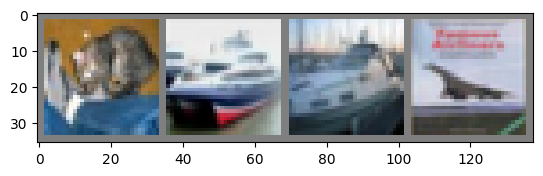

GroundTruth:  cat   ship  ship  plane
Accuracy: 0.429
Precision: 0.445
Recall: 0.429
F1-score: 0.419


In [ ]:
# test your CNN on the test set
# Note: If your accuracy is low, you need to further train your CNN.
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

# What is the accuracy, precision, recall and F1-score on the test dataset?
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)

y_test = []
y_test_predictions = []

net.eval()
for i, data in enumerate(testloader, 0):
    inputs, labels = data
    y_test.extend([i.item() for i in labels])

    outputs = net(inputs)
    y_test_predictions.extend(torch.argmax(i).item() for i in outputs)

# Compute accuracy, precision, recall, and F1-score
accuracy = accuracy_score(y_test, y_test_predictions)
precision = precision_score(y_test, y_test_predictions, average='weighted')
recall = recall_score(y_test, y_test_predictions, average='weighted')
f1 = f1_score(y_test, y_test_predictions, average='weighted')

# print accuracy, prec, rec, f1-score here
print(f'Accuracy: {accuracy:.3f}')
print(f'Precision: {precision:.3f}')
print(f'Recall: {recall:.3f}')
print(f'F1-score: {f1:.3f}')

## Part 2: Using a Pre-trained CNN to Detect Cyberbullying in Images

With previous lab learning, you should have some knowledge about how to develop an AI model to detect cyberbullying lauguage. In this lab, we will keep learning how AI can be developed to detect cyberbullying. We will use a publicly available test dataset of cyberbullying images, and deploy an pre-trained AI model to automatically detect cyberbullying images.
Approach towards analysing the cyber bullying in images in a dataset, there are three steps:
1. Understand and identify the factors related to cyberbullying in images.
2. Load the pre-trained model.
3. Fine-tune the model with a small dataset.
3. Evaluate the pre-trained model and your fine-tuned model with the same test dataset.
 - Get the results of accuracy, precision, recall and F1-score
 - plot out the confusion matrix figure

 The models and datasets in this lab are taken from the paper "Towards Understanding and Detecting Cyberbullying in Real-world Images" (NDSS 2021). https://www.ndss-symposium.org/ndss-paper/towards-understanding-and-detecting-cyberbullying-in-real-world-images/

## Download the pre-trained model, test dataset and the dependencies

First, we need to download the pre-trained model and the test dataset used in the lab. Just hit the 'play' button run the code below.

In [ ]:
 # download the model and dataset
!wget -O auxes_17.pt https://buffalo.box.com/shared/static/cjk39hq7prpwj2rkqz6lc2jr6q2h5shy.pt # model checkpoints
!wget -O cyberbullying_data.zip https://github.com/cuadvancelab/materials/blob/main/lab2/cyberbullying_data.zip?raw=true # test dataset

--2024-10-20 18:10:51--  https://buffalo.box.com/shared/static/cjk39hq7prpwj2rkqz6lc2jr6q2h5shy.pt
Resolving buffalo.box.com (buffalo.box.com)... 74.112.186.157
Connecting to buffalo.box.com (buffalo.box.com)|74.112.186.157|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /public/static/cjk39hq7prpwj2rkqz6lc2jr6q2h5shy.pt [following]
--2024-10-20 18:10:51--  https://buffalo.box.com/public/static/cjk39hq7prpwj2rkqz6lc2jr6q2h5shy.pt
Reusing existing connection to buffalo.box.com:443.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://buffalo.app.box.com/public/static/cjk39hq7prpwj2rkqz6lc2jr6q2h5shy.pt [following]
--2024-10-20 18:10:51--  https://buffalo.app.box.com/public/static/cjk39hq7prpwj2rkqz6lc2jr6q2h5shy.pt
Resolving buffalo.app.box.com (buffalo.app.box.com)... 74.112.186.157
Connecting to buffalo.app.box.com (buffalo.app.box.com)|74.112.186.157|:443... connected.
HTTP request sent, awaiting response... 302 Fo

In [ ]:
# unzip the test data
%%capture
!unzip "/content/cyberbullying_data.zip" -d "/content"

Let's import all our softwares dependencies in our iPython notebook

In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import torch.utils.data as data_utils
import torchvision.transforms as transforms
from torchvision import models
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader

In [ ]:
import pickle
import gzip
import sys
import time
import numpy as np
import math
import os
import random
from skimage import io, transform

## How to identify cyberbullying in images

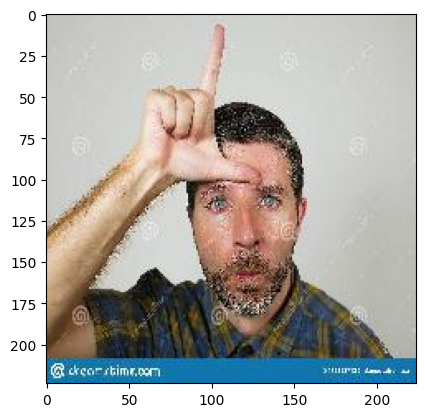

In [ ]:
# @title An example image
# importing required libraries
import matplotlib.pyplot as plt
import matplotlib.image as img

# reading the image
testImage = img.imread('/content/cyberbullying_data/cyberbullying_data_splits_clean/test/cyberbullying/7.s-s-unshaven-sad-ashamed-man-doing-loser-sign-hand-fingers-his-front-funny-depressed-face-expression-s-139158713.jpg')

# displaying the image
plt.imshow(testImage)

**5 FACTORS to measurement cyberbulling in images**
- Body-pose
- Facial Emotion
- Object
- Gesture
- Social Factors

<img src="https://github.com/cuadvancelab/materials/blob/main/lab2/factors.png?raw=true" alt="drawing" width="600"/>

The follow table shows the analysis of cyberbulling factors in images. Higher value of cosine similarity indicates higher correlation.

| Factor        | Attribute           |  Cyberbulling  |  Non-cyberbulling  |  Description  |
| ------------- |:----------:|:-----:|:-----:| ------------- :|
| Body-pose      | Front pose <br> Non-front pose | 0.86<br>0.50 | 0.53 <br> 0.84 | Pose of subject in image is towards the viewer |
| Emotion      | Joy <br> Sorrow <br> Anger <br> Surprise | 0.34<br>0.02<br>0.09<br>0.07 | 0.25<br>0.02<br>0.04<br>0.05 | Facial emotion of subject in image|
| Gesture      | Hand gesture <br> No hand gesture | 0.71<br>0.70 | 0.32 <br> 0.94 | Hand gesture made by subject in imager |
| Object      | Threatening object <br> No threatening object | 0.33<br>0.94 | 0.06 <br> 0.99 | Threatening object present in image |
| Social      | Anti-LGBT <br> Anti-black racism | 0.45<br>0.03 | 0.06 <br> 0.00 | Anti-LGBT symbols and anti-black racism in image |

More details can be found in 2021 NDSS paper: <em>Towards Understanding and Detecting Cyberbullying in Real-world Images</em> [link](https://www.ndss-symposium.org/wp-content/uploads/ndss2021_7C-4_24260_paper.pdf)

## Load datasets

Now, let's run the subsequent codes to load your data from a predefined
class

In [ ]:
class PosesDataset(Dataset):

  def __init__(self, root_dir, poses_dir, auxes_dir):

    self.samples = []
    self.root_dir = root_dir
    self.poses_dir = poses_dir
    self.auxes_dir = auxes_dir

    for _, _, cb_images in os.walk(self.root_dir + 'cyberbullying'): break
    for _, _, non_cb_images in os.walk(self.root_dir + 'non_cyberbullying'): break
    for _, _, cb_poses in os.walk(self.poses_dir + 'cyberbullying'): break
    for _, _, non_cb_poses in os.walk(self.poses_dir + 'non_cyberbullying'): break

    for i in cb_images:
      self.samples.append((self.root_dir + 'cyberbullying/' + i, self.poses_dir + 'cyberbullying/' + i, self.auxes_dir + 'cyberbullying/' + i, 1))

    for i in non_cb_images:
      self.samples.append((self.root_dir + 'non_cyberbullying/' + i, self.poses_dir + 'non_cyberbullying/' + i, self.auxes_dir + 'non_cyberbullying/' + i, 0))


  def __len__(self):
    return len(self.samples)

  def __getitem__(self, idx):
    if torch.is_tensor(idx):
      idx = idx.tolist()

    img_name, pose_name, aux_name, label = self.samples[idx]
    image = io.imread(img_name)

    aux = pickle.load(open(aux_name + '.p', 'rb'))
    aux = torch.tensor(aux)

    # drop the alpha channel for some images
    if image.shape == (224, 224):
      # handle grayscale images
      image = np.stack([image, image, image], axis=2)

    if image.shape == (224, 224, 4):
      image = image[:,:,:3]

    image = image.transpose((2, 0, 1)) # C X H X W
    pose = io.imread(pose_name)
    if pose.shape != (224, 224):
      pose = pose[:,:,0]
    pose = np.expand_dims(pose, axis = 0)
    image = np.concatenate((image, pose), axis = 0)
    sample = {'image': torch.from_numpy(image.copy()).float() / 255, 'aux': aux, 'label': label}
    return sample

In [ ]:
test_set = PosesDataset('cyberbullying_data/cyberbullying_data_splits_clean/test/', 'cyberbullying_data/cyberbullying_poses/test/', 'cyberbullying_data/cyberbullying_data_auxes/test/')
test_loader = torch.utils.data.DataLoader(test_set, batch_size = 1, shuffle = True)

## Load pre-trained AI model

We will use GPU to test our AI if it is available.

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

The AI model prediction process looks like the following figure.
<img src="https://github.com/cuadvancelab/materials/blob/main/lab2/model.png?raw=true" alt="drawing" width="700"/>

In our AI model, we combine the low level image features with the cyberbulling factors identified before. We combine these features using feature fusion techniques.

We use the `VGG16` pre-trained model for image features `CNN` and use a multi-layer perceptron model `MLP` for the factors related features, and combine the feature vectors from both these models using late fusion.

Let's load the pre-trained model to test its capability

In [ ]:
# load vgg16 pre-trained model
orig = models.vgg16(pretrained = True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
class CB(nn.Module):
  def __init__(self):
    super(CB, self).__init__()
    self.conv1 = nn.Conv2d(4, 3, 1)
    self.f = nn.Sequential(*list(orig.features.children()))
    self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
    self.aux_classifier = nn.Sequential(
      nn.Linear(25097, 1024),
      nn.ReLU(),
      nn.Linear(1024, 25088),
      nn.ReLU()
    )
    self.classifier = nn.Sequential(*list(orig.classifier.children()))
    self.classifier[-1] = nn.Linear(4096, 2)
    self.sig = nn.Sigmoid()

  def forward(self, x, aux):
    x = self.conv1(x)
    x = self.f(x)
    x = self.avgpool(x)
    x = torch.flatten(x, 1)
    x = torch.cat((x, aux), dim = 1)
    x = self.aux_classifier(x)
    x = self.classifier(x)
    x = self.sig(x)


    return x


Pass the pre-trained checkpoints to the VGG model so that you can have our pre-trained model

In [ ]:
model = torch.load("auxes_17.pt", map_location=torch.device('cpu')) # Model Load to CPU
model.to(device)

running_loss = []
criterion = nn.CrossEntropyLoss()
correct, incorrect, total = 0., 0., 0.

<ipython-input-54-fc54d528251d>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load("auxes_17.pt", map_location=torch.device('cpu')) # Model Load to CPU


## Generate the detection resuls for test data

Now, it's time to evaulate the pre-trained model's capability with our test dataset

In [ ]:
with torch.no_grad():
  for i_v, data_v in enumerate(test_loader):
    x_test, y_test, aux_test = data_v['image'], data_v['label'], data_v['aux']
    x_test, y_test, aux_test = x_test.to(device), y_test.to(device, dtype = torch.long), aux_test.to(device, dtype = torch.float)
    y_test_ = model(x_test, aux_test) # forward pass for the pre-trained model
    running_loss.append(criterion(y_test_, y_test))
    _, predicted = torch.max(y_test_.data, 1)
    total += y_test.size(0)
    correct += (predicted == y_test).sum().item()

print('Test loss is: {:.3f}'.format((sum(running_loss) / len(running_loss)).item()))
print('The accuracy for test dataset is: {}%'.format((correct / total) * 100))


Test loss is: 0.442
The accuracy for test dataset is: 85.0%



- - - -
**<font color='red'>Task 1:</font>
Write code to generate result report contains: Accuracy, Precision, Recall and F1-Score**
- - - -
reference link: https://en.wikipedia.org/wiki/F-score
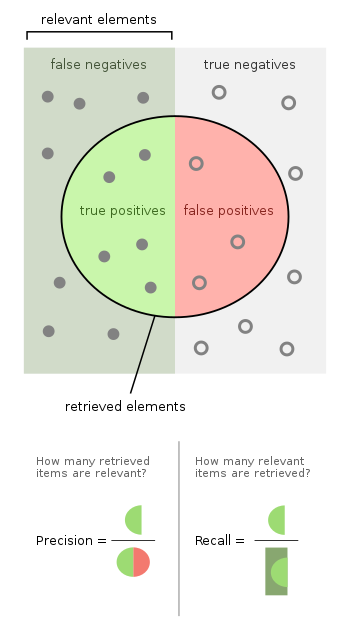

In [ ]:
# get the acc, precision, recall, f1 score for the test set

tp, tn, fp, fn = 0, 0, 0, 0

model.eval()
with torch.no_grad():
    for i_v, data_v in enumerate(test_loader):
        x_test, y_test, aux_test = data_v['image'], data_v['label'], data_v['aux']
        x_test, y_test, aux_test = x_test.to(device), y_test.to(device, dtype = torch.long), aux_test.to(device, dtype = torch.float)
        y_test_ = model(x_test, aux_test) # forward pass for the fine-tuned model
        _, predicted = torch.max(y_test_.data, 1)
        if y_test == 1 and predicted == 1:
            tp += 1
        elif y_test == 1 and predicted == 0:
            fn += 1
        elif y_test == 0 and predicted == 1:
            fp += 1
        elif y_test == 0 and predicted == 0:
            tn += 1

In [ ]:
# TODO: Complete the following code to calculate the accuracy, precision, recall and F1 score.
acc = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

print('The accuracy for test dataset is: {}%'.format(acc * 100))
print('The precision for test dataset is: {}%'.format(precision * 100))
print('The recall for test dataset is: {}%'.format(recall * 100))
print('The f1 score for test dataset is: {}%'.format(f1 * 100))

The accuracy for test dataset is: 85.0%
The precision for test dataset is: 88.88888888888889%
The recall for test dataset is: 80.0%
The f1 score for test dataset is: 84.21052631578948%



- - - -
**<font color='red'>Task 2:</font>
Write code to plot the confusion matrix** (you are allowed to borrow any python tools, such as scikit-learn (https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html))
- - - -

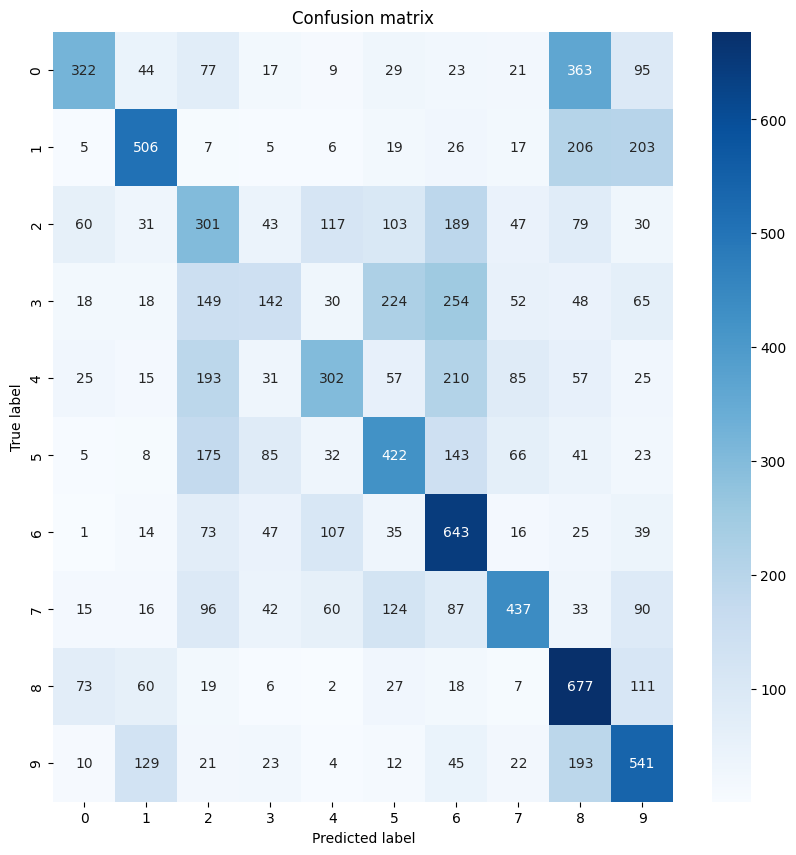

In [ ]:
# Complete the following code to get the confusion matrix for the test set
# get the confusion matrix for the test set
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_true = []
y_pred = []

# TODO: Write the code to get the y_true and y_pred lists for the test set
# your code here:
net.eval()  # Put the model in evaluation mode
with torch.no_grad():  # Disable gradient calculation
    for data in testloader:
        inputs, labels = data

        # Move inputs and labels to the device (GPU or CPU)
        inputs, labels = inputs.to(device), labels.to(device)

        # Get model predictions
        outputs = net(inputs)
        _, predicted = torch.max(outputs, 1)  # Get the index of the max log-probability

        # Add true and predicted labels to the lists
        y_true.extend(labels.cpu().numpy())  # Convert tensors to numpy arrays and add them to y_true
        y_pred.extend(predicted.cpu().numpy())  # Convert tensors to numpy arrays and add them to y_pred

# get the confusion matrix
cm = confusion_matrix(y_true, y_pred)
# cm

# plot the confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.title("Confusion matrix")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

## Let's check with one instance

To better understand the performance, you can try to visualize one instance in the dataset

In [ ]:
# check how many test data samples we have
print(f"we have {len(test_set)} samples in our test dataset, you can choose any of them to see the prediction.")

we have 20 samples in our test dataset, you can choose any of them to see the prediction.


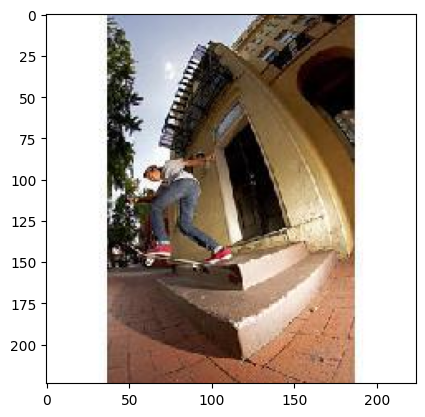


The label of this image is: non-cyberbullying


In [ ]:
#@markdown Select a number to view the image and its label.

picture_index  = "17" #@param [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]
index = int(picture_index)
instance = test_set[index]

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread(test_set.samples[index][0])
imgplot = plt.imshow(img)
plt.show()
annot_label = "cyberbullying" if test_set[index]['label']==1 else "non-cyberbullying"
print('')
print("The label of this image is: {}".format(annot_label))

Run the following code cell to check the AI's prediction

In [ ]:
# check if the prediction is correct
instance_image, instance_label, instance_aux = instance['image'].to(device), torch.tensor(instance['label']).to(device, dtype = torch.long), instance['aux'].to(device, dtype = torch.float)

output = model(instance_image.unsqueeze(0), instance_aux.unsqueeze(0)).data
_, prediction = torch.max(output.data, 1)
predict_label = "cyberbullying" if prediction.item()==1 else "non-cyberbullying"
comparision = "correct" if prediction==instance_label else "not correct"

print("The AI prediction for this image is: {}, which is {}!".format(predict_label, comparision))

The AI prediction for this image is: non-cyberbullying, which is correct!


## Model Fine-Tuning



- - - -
**<font color='red'>Task 3:</font>
Write code to fine-tune the model with the training dataset**

**The training dataset will be prepared via the following code cells.**

- - - -

In [ ]:
# download the training data
!wget -O cyberbullying_train_data.zip https://buffalo.box.com/shared/static/4tq3wxly5pk2k8hpx7brvtr89icx7e7f.zip

--2024-10-20 18:13:29--  https://buffalo.box.com/shared/static/4tq3wxly5pk2k8hpx7brvtr89icx7e7f.zip
Resolving buffalo.box.com (buffalo.box.com)... 74.112.186.157
Connecting to buffalo.box.com (buffalo.box.com)|74.112.186.157|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /public/static/4tq3wxly5pk2k8hpx7brvtr89icx7e7f.zip [following]
--2024-10-20 18:13:29--  https://buffalo.box.com/public/static/4tq3wxly5pk2k8hpx7brvtr89icx7e7f.zip
Reusing existing connection to buffalo.box.com:443.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://buffalo.app.box.com/public/static/4tq3wxly5pk2k8hpx7brvtr89icx7e7f.zip [following]
--2024-10-20 18:13:29--  https://buffalo.app.box.com/public/static/4tq3wxly5pk2k8hpx7brvtr89icx7e7f.zip
Resolving buffalo.app.box.com (buffalo.app.box.com)... 74.112.186.157
Connecting to buffalo.app.box.com (buffalo.app.box.com)|74.112.186.157|:443... connected.
HTTP request sent, awaiting response... 3

In [ ]:
# unzip the training data
%%capture
!unzip "/content/cyberbullying_train_data.zip" -d "/content"

In [ ]:
# prepare the training data
train_set = PosesDataset('cyberbullying_train_data/cyberbullying_data_splits_clean/train/', 'cyberbullying_train_data/cyberbullying_poses/train/', 'cyberbullying_train_data/cyberbullying_data_auxes/train/')
# remove .DS_Store files if they exist
train_set.samples = [x for x in train_set.samples if '.DS_Store' not in x[0]]
# prepare the dataloader
train_loader = torch.utils.data.DataLoader(train_set, batch_size = 12, shuffle = True)

In [ ]:
# copy the pre-trained model for fine-tuning
# Load the model to the CPU using map_location
ft_model = torch.load("auxes_17.pt", map_location=torch.device('cpu'))
ft_model.to(device)

<ipython-input-65-1a45dcda840f>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ft_model = torch.load("auxes_17.pt", map_location=torch.device('cpu'))


CB(
  (conv1): Conv2d(4, 3, kernel_size=(1, 1), stride=(1, 1))
  (f): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPo

In [ ]:
# prepare the optimizer, loss function, learning rate
optimizer = optim.Adam(ft_model.parameters(), lr = 1e-4)

In [ ]:
# TODO: complete the following code by replace "___", to mimic fine-tune (further training) the model
ft_model.train()

epochs = 2 # Assign an integer value to epochs, e.g., 2
running_loss = [] # Initialize a list to store the running loss

for epoch in range(epochs):
  correct, incorrect, total = 0, 0, 0 # Initialize correct, incorrect, and total for the epoch
  total_loss = 0 # Initialize total_loss for the epoch

  for i, data in enumerate(train_loader):
        inputs = data['image'].to(device)
        aux = data['aux'].to(device)
        labels = data['label'].to(device)
        optimizer.zero_grad() # zero the parameter gradients
        outputs = ft_model(inputs, aux) # forward pass
        loss = criterion(outputs, labels) # compute loss via comparing model's outputs and our predefined labels
        loss.backward() # backward pass
        optimizer.step() # update weights
        running_loss.append(loss.item()) # save loss
        _, predicted = torch.max(outputs.data, 1) # get predictions
        total += labels.size(0) # update total
        correct += (predicted == labels).sum().item() # update correct predictions
        if i % 50 == 0: # print every 50 mini-batches
            print('Epoch: %d, Iteration: %d, Loss: %.4f, Accuracy: %.4f' % (epoch, i, loss.item(), correct / total))
            correct, incorrect, total = 0.0, 0.0,0.0 # reset correct, incorrect, and total. hint: float is better than int

# Note:
# This code is a very basic version that helps us keep training the model with the training set,
# Recall from the last lecture, we can have a validation set to help us decide when to stop training
# the model.
# If you are interested, you can try to split the training set into training set and validation set,
# and use the validation set to help you decide when to stop training the model

Epoch: 0, Iteration: 0, Loss: 0.3966, Accuracy: 0.9167



- - - -
**<font color='red'>Task 4:</font>
Write code to print out your fine-tuned model's results, you can refer the code how we generate results for test dataset previously.**

**Compare the the two results you get, is the prediction accuracy better than the previous model?
If not, think about the reasons for it perhaps.**
- - - -

In [ ]:
ft_model.eval()
# TODO: write code to evaluate the model on the test set

# Initialize variables to track total and correct predictions (original part)
total = 0.0
correct = 0.0

# Initialize variables to store true positives, true negatives, false positives, and false negatives (detailed part)
tp, tn, fp, fn = 0, 0, 0, 0

# To store y_true and y_pred for the confusion matrix and detailed evaluation
y_true = []
y_pred = []

# Disable gradient calculation for evaluation
with torch.no_grad():
    for data in test_loader:
        # Get inputs and move to the device (GPU/CPU)
        inputs = data['image'].to(device)
        aux = data['aux'].to(device)
        labels = data['label'].to(device)

        # Forward pass to get model outputs
        outputs = ft_model(inputs, aux)

        # Get predicted class by taking the index with the highest score
        _, predicted = torch.max(outputs.data, 1)

        # Update total number of labels
        total += labels.size(0)

        # Update correct predictions count
        correct += (predicted == labels).sum().item()

        # Store true and predicted labels for detailed evaluation
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

        # Manually compute true positives, false negatives, false positives, and true negatives
        for y_t, y_p in zip(labels.cpu().numpy(), predicted.cpu().numpy()):
            if y_t == 1 and y_p == 1:
                tp += 1
            elif y_t == 1 and y_p == 0:
                fn += 1
            elif y_t == 0 and y_p == 1:
                fp += 1
            elif y_t == 0 and y_p == 0:
                tn += 1

# Calculate accuracy (original part)
accuracy = correct / total
print(f'Accuracy of the fine-tuned model on the test dataset: {accuracy:.4f}')

# Calculate precision, recall, and F1 score (detailed part)
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

# Print the detailed metrics
print('Fine-tuned model detailed evaluation:')
print(f'Accuracy: {accuracy * 100:.2f}%')
print(f'Precision: {precision * 100:.2f}%')
print(f'Recall: {recall * 100:.2f}%')
print(f'F1 Score: {f1 * 100:.2f}%')

# Print confusion matrix counts
print(f'True Positives: {tp}, False Negatives: {fn}, False Positives: {fp}, True Negatives: {tn}')


Accuracy of the fine-tuned model on the test dataset: 0.6500
Fine-tuned model detailed evaluation:
Accuracy: 65.00%
Precision: 100.00%
Recall: 30.00%
F1 Score: 46.15%
True Positives: 3, False Negatives: 7, False Positives: 0, True Negatives: 10



- - - -
**<font color='red'>Task 5:</font>
Write code to visualize the image "/content/cyberbullying_data/cyberbullying_data_splits_clean/test/cyberbullying/fingerGunAnnotated_239.JPEG".<br>
Then test this image with the fine-tuned model and print the prediction results.**
- - - -

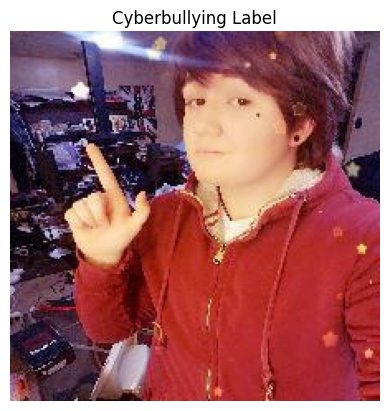

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import torch
from torchvision import transforms

# Load the image
image_path = "/content/cyberbullying_data/cyberbullying_data_splits_clean/test/cyberbullying/fingerGunAnnotated_239.JPEG"
img = Image.open(image_path)

# Plot the image with its label (you can adjust the label as needed)
plt.imshow(img)
plt.axis('off')  # Hide axis for cleaner display
plt.title("Cyberbullying Label")  # Change to actual label if available
plt.show()

# Define the transformations (make sure these match the transformations used during training)
transform = transforms.Compose([
    transforms.Resize((250, 250)),  # Resize to the input size expected by the model
    transforms.ToTensor(),          # Convert the image to a tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize using ImageNet stats
])

# Apply transformations and add a batch dimension
img_transformed = transform(img).unsqueeze(0)  # Add batch dimension

# Move the image to the device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
img_transformed = img_transformed.to(device)

In [ ]:
# TODO: find the picture_index of the chosen image by comparing with the previous visualization cell
picture_index = None
for idx, instance in enumerate(test_set):
    img_instance = instance['image'].to(device)
    if torch.equal(img_instance, img_transformed.squeeze(0)):  # Compare transformed images
        picture_index = idx
        break

# If the image is found, proceed with prediction
if picture_index is not None:
    instance = test_set[picture_index]
    print(f"Image found in the dataset at index: {picture_index}")

    # Retrieve the image, label, and auxiliary data for prediction
    instance_image = instance['image'].to(device)
    instance_label = torch.tensor(instance['label']).to(device, dtype=torch.long)
    instance_aux = instance['aux'].to(device, dtype=torch.float)

    # Set the model to evaluation mode
    ft_model.eval()

    # Disable gradient calculations for inference
    with torch.no_grad():
        # Get model predictions, providing the auxiliary input
        output = ft_model(instance_image.unsqueeze(0), aux=instance_aux.unsqueeze(0))
        _, predicted_class = torch.max(output.data, 1)

        # Assuming you have a list of class names
        class_names = ['non-cyberbullying', 'cyberbullying']  # Replace with your actual class names

        # Print the prediction result
        print(f'Predicted class: {class_names[predicted_class.item()]}')
        print(f'Actual class: {class_names[instance_label.item()]}')

        # Check if the prediction is correct
        if predicted_class.item() == instance_label.item():
            print("The prediction is correct.")
        else:
            print("The prediction is incorrect.")
else:
    print("Image not found in the dataset.")

Image not found in the dataset.
